# FINAL PROJECT

# Introduction/Business Problem 

According to the tripavisor 

## Data

In [ ]:
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.
New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset
All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.
• FourSquare be used to locate all venues and then filtered by Japanese restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.
• Data will be sorted based on rankings.
• Finally, the data be will be visually assessed using graphing from Python libraries.

# Is Manhattan the only place to succed with a Latin American Restaurant business?

Import all necesary libraries 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')  

Solving environment: done

# All requested packages already installed.

Libraries imported.


My Credentials

In [2]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'QS10IG0UKS1QSUIOJUZDJ2FY4CFDCIUIENUUW5ZIDPGOXG5C' # your Foursquare ID
CLIENT_SECRET = 'Q0ZHVG10RX0VMZEASB0WTPGG5JWCIAW1DEALJCUFRUWJYLR2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## We are using these 4 functions
1. get_new_york_data: We will get the list of Neighborhoods, Borough, Latitude, Longitude.
2. geo_location: To find the latitude and longitude for a place
3. get_venues: Given the first point we will see list of main venues.
4. get_venues_detail: Data detail will be collected in order to be analyzed

In [3]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df




### 1. Explore the NY Data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
#There are 306 different neightborhood
len (ny_data)

306

In [14]:
check1 = ny_data.groupby(["Borough"]).count()
check1 # queens has most neighborhoods

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


In [8]:
# prepare neighborhood list that contains Latin American Restaurants 
column_names=['Borough', 'Neighborhood', 'ID','Name']
Lat_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Lat_restaurants=venues[venues['Category']=='Latin American Restaurant']   
    print('(',count,'/',len(ny_data),')','Latin American Restaurant in '+Neighborhood+', '+Borough+':'+str(len(Lat_restaurants)))
    print(row)
    for resturant_detail in Lat_restaurants.values.tolist():
        id, name , category=resturant_detail
        Lat_rest_ny = Lat_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Latin American Restaurant in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Latin American Restaurant in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Latin American Restaurant in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Latin American Restaurant in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Latin American Restaurant in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Latin American Restaurant in Kingsbridge, Bronx:3
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Latin American Restaurant in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Latin American Restaurant in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 

( 65 / 306 ) Latin American Restaurant in Brooklyn Heights, Brooklyn:0
['Brooklyn', 'Brooklyn Heights', 40.695863722724084, -73.99378225496424]
( 66 / 306 ) Latin American Restaurant in Cobble Hill, Brooklyn:0
['Brooklyn', 'Cobble Hill', 40.687919722485574, -73.99856139218463]
( 67 / 306 ) Latin American Restaurant in Carroll Gardens, Brooklyn:1
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Latin American Restaurant in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Latin American Restaurant in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Latin American Restaurant in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Latin American Restaurant in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Latin American Restaurant in Cypress Hills, Brookl

( 126 / 306 ) Latin American Restaurant in Morningside Heights, Manhattan:0
['Manhattan', 'Morningside Heights', 40.807999738165826, -73.96389627905332]
( 127 / 306 ) Latin American Restaurant in Gramercy, Manhattan:1
['Manhattan', 'Gramercy', 40.737209832715, -73.98137594833541]
( 128 / 306 ) Latin American Restaurant in Battery Park City, Manhattan:0
['Manhattan', 'Battery Park City', 40.71193198394565, -74.01686930508617]
( 129 / 306 ) Latin American Restaurant in Financial District, Manhattan:0
['Manhattan', 'Financial District', 40.70710710727048, -74.0106654452127]
( 130 / 306 ) Latin American Restaurant in Astoria, Queens:0
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Latin American Restaurant in Woodside, Queens:3
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Latin American Restaurant in Jackson Heights, Queens:4
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Latin American Restauran

( 189 / 306 ) Latin American Restaurant in Laurelton, Queens:0
['Queens', 'Laurelton', 40.66788389660247, -73.74025607989822]
( 190 / 306 ) Latin American Restaurant in Lefrak City, Queens:0
['Queens', 'Lefrak City', 40.736074570830795, -73.8625247141374]
( 191 / 306 ) Latin American Restaurant in Belle Harbor, Queens:0
['Queens', 'Belle Harbor', 40.57615556543109, -73.8540175039252]
( 192 / 306 ) Latin American Restaurant in Rockaway Park, Queens:0
['Queens', 'Rockaway Park', 40.58034295646131, -73.84153370226186]
( 193 / 306 ) Latin American Restaurant in Somerville, Queens:0
['Queens', 'Somerville', 40.59771061565768, -73.79664750844047]
( 194 / 306 ) Latin American Restaurant in Brookville, Queens:0
['Queens', 'Brookville', 40.66000322733613, -73.75175310731153]
( 195 / 306 ) Latin American Restaurant in Bellaire, Queens:0
['Queens', 'Bellaire', 40.73301404027834, -73.73889198912481]
( 196 / 306 ) Latin American Restaurant in North Corona, Queens:0
['Queens', 'North Corona', 40.754

( 248 / 306 ) Latin American Restaurant in Carnegie Hill, Manhattan:0
['Manhattan', 'Carnegie Hill', 40.7826825671257, -73.95325646837112]
( 249 / 306 ) Latin American Restaurant in Noho, Manhattan:0
['Manhattan', 'Noho', 40.72325901885768, -73.98843368023597]
( 250 / 306 ) Latin American Restaurant in Civic Center, Manhattan:0
['Manhattan', 'Civic Center', 40.71522892046282, -74.00541529873355]
( 251 / 306 ) Latin American Restaurant in Midtown South, Manhattan:0
['Manhattan', 'Midtown South', 40.7485096643122, -73.98871313285247]
( 252 / 306 ) Latin American Restaurant in Richmond Town, Staten Island:0
['Staten Island', 'Richmond Town', 40.56960594275505, -74.1340572986257]
( 253 / 306 ) Latin American Restaurant in Shore Acres, Staten Island:0
['Staten Island', 'Shore Acres', 40.60971934079284, -74.06667766061771]
( 254 / 306 ) Latin American Restaurant in Clifton, Staten Island:0
['Staten Island', 'Clifton', 40.61917845202843, -74.072642445484]
( 255 / 306 ) Latin American Restaura

## 2. Explore Latino Restaurant in NY Data

In [15]:
#Create a CSV File
Lat_rest_ny.to_csv('Lat_rest_ny.csv') 

In [16]:
Lat_ny = pd.read_csv('Lat_rest_ny.csv')
Lat_rest_ny.tail()

,Borough,Neighborhood,ID,Name
54,Queens,Hunters Point,4a903faef964a520ca1620e3,Blend LIC
55,Brooklyn,Vinegar Hill,4ab11a2af964a5200b6820e3,Los Papis
56,Brooklyn,Highland Park,5f2b6d971e486233644ffbb6,El Ambiente
57,Bronx,Kingsbridge Heights,4bbe1149078095214562db91,La Caridad
58,Bronx,Kingsbridge Heights,5143a0d5e4b087df70ee760c,Caridad Restaurant at Kingsbridge


In [17]:
#There are 39 Latinamerican Restaurants in NY
len(Lat_rest_ny)

59

In [33]:
Check2= Lat_rest_ny.groupby(["Borough"]).count()
Check2

,Neighborhood,ID,Name
Borough,,,
Bronx,14,14,14
Brooklyn,18,18,18
Manhattan,11,11,11
Queens,16,16,16


In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Lat_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in Lat_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Lat_rest_ny),')','processed')
    Lat_rest_stats_ny = Lat_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
Lat_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f3094d6e70bb116feefb43f'}, 'response': {'venue': {'id': '55297008498e9286460da191', 'name': 'Leche y Miel', 'contact': {'phone': '7187085787', 'formattedPhone': '(718) 708-5787'}, 'location': {'address': '5761 Broadway', 'crossStreet': '236th Street', 'lat': 40.883742, 'lng': -73.90185699999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.883742, 'lng': -73.90185699999999}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5761 Broadway (236th Street)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/leche-y-miel/55297008498e9286460da191', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '5f3095286c6649482649a65f'}, 'response': {'venue': {'id': '4e8b34c561afcc24d9a236ca', 'name': 'Silhouette Restaurant & Lounge', 'contact': {'phone': '7186010777', 'formattedPhone': '(718) 601-0777', 'twitter': 'silhouetterl'}, 'location': {'address': '5668 Broadway', 'lat': 40.88070643866, 'lng': -73.90268654351613, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88070643866, 'lng': -73.90268654351613}, {'label': 'entrance', 'lat': 40.880896, 'lng': -73.902679}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5668 Broadway', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/silhouette-restaurant--lounge/4e8b34c561afcc24d9a236ca', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '5f309509d602790ae622bb21'}, 'response': {'venue': {'id': '52c1ad2c498ebd959c9818e1', 'name': 'Hola España', 'contact': {'phone': '3478437894', 'formattedPhone': '(347) 843-7894'}, 'location': {'address': '5586 Broadway', 'crossStreet': '231', 'lat': 40.87915969295343, 'lng': -73.90455296034935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87915969295343, 'lng': -73.90455296034935}, {'label': 'entrance', 'lat': 40.879106, 'lng': -73.904456}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5586 Broadway (231)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hola-espa%C3%B1a/52c1ad2c498ebd959c9818e1', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffi

{'meta': {'code': 200, 'requestId': '5f3095037ad0a56d2407b823'}, 'response': {'venue': {'id': '4b45e6e5f964a520fc1126e3', 'name': '188 Bakery Cuchifritos', 'contact': {'phone': '7183674500', 'formattedPhone': '(718) 367-4500'}, 'location': {'address': '158 E 188th St', 'crossStreet': 'at Grand Concourse', 'lat': 40.861601957429656, 'lng': -73.89831076218098, 'labeledLatLngs': [{'label': 'display', 'lat': 40.861601957429656, 'lng': -73.89831076218098}, {'label': 'entrance', 'lat': 40.86152, 'lng': -73.898395}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['158 E 188th St (at Grand Concourse)', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/188-bakery-cuchifritos/4b45e6e5f964a520fc1126e3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.

{'meta': {'code': 200, 'requestId': '5f309297dfd3a31abba5a1cb'}, 'response': {'venue': {'id': '4b660f70f964a52061112be3', 'name': 'Parilla Latina', 'contact': {'phone': '7183293000', 'formattedPhone': '(718) 329-3000'}, 'location': {'address': '2501 Webster Ave', 'lat': 40.861009386607606, 'lng': -73.89194477395704, 'labeledLatLngs': [{'label': 'display', 'lat': 40.861009386607606, 'lng': -73.89194477395704}, {'label': 'entrance', 'lat': 40.861121, 'lng': -73.892198}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2501 Webster Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/parilla-latina/4b660f70f964a52061112be3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'prima

{'meta': {'code': 200, 'requestId': '5f309467dd2e0829bba901e2'}, 'response': {'venue': {'id': '4d8815c6401a224b07467218', 'name': 'El Valle Restaurant', 'contact': {'phone': '7183781774', 'formattedPhone': '(718) 378-1774'}, 'location': {'address': '794 Southern Blvd', 'crossStreet': 'Longwood Avenue', 'lat': 40.81611317943814, 'lng': -73.89630997108353, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81611317943814, 'lng': -73.89630997108353}], 'postalCode': '10455', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['794 Southern Blvd (Longwood Avenue)', 'Bronx, NY 10455', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-valle-restaurant/4d8815c6401a224b07467218', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '5f309519407e071762cf983f'}, 'response': {'venue': {'id': '4c4b596f712ac928d39dc56c', 'name': 'El Bohio Tropical Restaurant', 'contact': {'phone': '7184094442', 'formattedPhone': '(718) 409-4442'}, 'location': {'address': '20 Westchester Sq', 'lat': 40.840607260597984, 'lng': -73.84317651798457, 'labeledLatLngs': [{'label': 'display', 'lat': 40.840607260597984, 'lng': -73.84317651798457}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['20 Westchester Sq', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-bohio-tropical-restaurant/4c4b596f712ac928d39dc56c', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False

{'meta': {'code': 200, 'requestId': '5f3094eec02449411875cd30'}, 'response': {'venue': {'id': '4b8423d7f964a5203b2331e3', 'name': 'Sabrosura', 'contact': {'phone': '7185971344', 'formattedPhone': '(718) 597-1344', 'twitter': 'sabrosurany', 'facebook': '127223477310566', 'facebookUsername': 'SabrosuraRestaurantsNY', 'facebookName': 'Sabrosura'}, 'location': {'address': '1200 Castle Hill Ave', 'crossStreet': 'at Gleason Ave', 'lat': 40.8319356355082, 'lng': -73.85101898514029, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8319356355082, 'lng': -73.85101898514029}, {'label': 'entrance', 'lat': 40.832065, 'lng': -73.850888}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1200 Castle Hill Ave (at Gleason Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sabrosura/4b8423d7f964a5203b2331e3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'plur

{'meta': {'code': 200, 'requestId': '5f30948997f4146e0458ff55'}, 'response': {'venue': {'id': '4d3780a19784a09387e0d7e8', 'name': 'La Isla Cuchifritos', 'contact': {'phone': '7187489375', 'formattedPhone': '(718) 748-9375'}, 'location': {'address': '4920 5th Ave', 'lat': 40.64524495461266, 'lng': -74.01019971163103, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64524495461266, 'lng': -74.01019971163103}, {'label': 'entrance', 'lat': 40.645309, 'lng': -74.01029}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4920 5th Ave', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-isla-cuchifritos/4d3780a19784a09387e0d7e8', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5f3094efc02449411875d193'}, 'response': {'venue': {'id': '4f877b60e4b07f1a33a27d3f', 'name': 'Puerto Viejo', 'contact': {'phone': '7183983758', 'formattedPhone': '(718) 398-3758', 'twitter': 'puertoviejony', 'facebook': '171701786269323', 'facebookUsername': 'PuertoViejoNY', 'facebookName': 'Puerto Viejo'}, 'location': {'address': '564 Grand Ave', 'crossStreet': 'at Dean St', 'lat': 40.67892483112173, 'lng': -73.96196021638814, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67892483112173, 'lng': -73.96196021638814}], 'postalCode': '11238', 'cc': 'US', 'neighborhood': 'Crown h', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['564 Grand Ave (at Dean St)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/puertoviejony', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', '

{'meta': {'code': 200, 'requestId': '5f30950a7ad0a56d2407c920'}, 'response': {'venue': {'id': '50a978f5e4b09f72f3a657a4', 'name': 'Xixa', 'contact': {'phone': '7183888860', 'formattedPhone': '(718) 388-8860'}, 'location': {'address': '241 S 4th St', 'crossStreet': 'Driggs Ave & Roebling', 'lat': 40.71041009500999, 'lng': -73.95853132009505, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71041009500999, 'lng': -73.95853132009505}, {'label': 'entrance', 'lat': 40.710387, 'lng': -73.958546}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['241 S 4th St (Driggs Ave & Roebling)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xixa/50a978f5e4b09f72f3a657a4', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/la

{'meta': {'code': 200, 'requestId': '5f3094adaf3e194d406ba035'}, 'response': {'venue': {'id': '54eea57d498e7f1416b46ebb', 'name': 'Maite', 'contact': {'phone': '7183663090', 'formattedPhone': '(718) 366-3090'}, 'location': {'address': '159 Central Ave', 'lat': 40.699091138836756, 'lng': -73.92683757307063, 'labeledLatLngs': [{'label': 'display', 'lat': 40.699091138836756, 'lng': -73.92683757307063}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['159 Central Ave', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maite/54eea57d498e7f1416b46ebb', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5f3094802bbd331380088860'}, 'response': {'venue': {'id': '580bbed438faa26bf0ed9bf2', 'name': 'White Maize', 'contact': {'phone': '3479462493', 'formattedPhone': '(347) 946-2493'}, 'location': {'address': '277 Smith St', 'crossStreet': 'Smith and Sackett', 'lat': 40.68249983837224, 'lng': -73.99331251555338, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68249983837224, 'lng': -73.99331251555338}], 'postalCode': '11231', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['277 Smith St (Smith and Sackett)', 'New York, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/white-maize/580bbed438faa26bf0ed9bf2', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}, {'

{'meta': {'code': 200, 'requestId': '5f30952394af785f949b7837'}, 'response': {'venue': {'id': '52f7d70e11d203df776339da', 'name': 'Colonia Verde', 'contact': {'phone': '3476894287', 'formattedPhone': '(347) 689-4287', 'twitter': 'coloniaverde'}, 'location': {'address': '219 Dekalb Ave', 'lat': 40.689693418539875, 'lng': -73.97073816836266, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689693418539875, 'lng': -73.97073816836266}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['219 Dekalb Ave', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/colonia-verde/52f7d70e11d203df776339da', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 's

{'meta': {'code': 200, 'requestId': '5f3094a2b856fa49bb54885d'}, 'response': {'venue': {'id': '4c6457b058810f47e7f30b1e', 'name': 'El Gran Mar de Plata', 'contact': {}, 'location': {'address': '3175 Fulton St', 'lat': 40.68216987577137, 'lng': -73.87786514645846, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68216987577137, 'lng': -73.87786514645846}, {'label': 'entrance', 'lat': 40.682209, 'lng': -73.877622}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3175 Fulton St', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-gran-mar-de-plata/4c6457b058810f47e7f30b1e', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '5f309537fa01662f629a9d42'}, 'response': {'venue': {'id': '4c5d86c02815c928b1fdb467', 'name': 'El Pulgarcito De America: Restaurant Y Pupuseria', 'contact': {'phone': '7186477762', 'formattedPhone': '(718) 647-7762'}, 'location': {'address': '3133 Fulton St', 'lat': 40.681816, 'lng': -73.879462, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681816, 'lng': -73.879462}, {'label': 'entrance', 'lat': 40.681708, 'lng': -73.879422}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3133 Fulton St', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-pulgarcito-de-america-restaurant-y-pupuseria/4c5d86c02815c928b1fdb467', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinam

{'meta': {'code': 200, 'requestId': '5f3094c518cb1d45725cecb5'}, 'response': {'venue': {'id': '4c2cf1007d85a593cabf51f3', 'name': 'Flatbush Latin Grill', 'contact': {}, 'location': {'address': '1902 Church Ave', 'lat': 40.649627, 'lng': -73.96195300000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.649627, 'lng': -73.96195300000001}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1902 Church Ave', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/flatbush-latin-grill/4c2cf1007d85a593cabf51f3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'},

{'meta': {'code': 200, 'requestId': '5f30942566f09152f196cf6f'}, 'response': {'venue': {'id': '4ab3ef09f964a5202e6f20e3', 'name': 'La Isla Restaurant', 'contact': {'phone': '7183871605', 'formattedPhone': '(718) 387-1605'}, 'location': {'address': '293 Broadway', 'crossStreet': 'at Marcy Ave', 'lat': 40.70851517863368, 'lng': -73.95818594678389, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70851517863368, 'lng': -73.95818594678389}, {'label': 'entrance', 'lat': 40.70861, 'lng': -73.958135}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['293 Broadway (at Marcy Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-isla-restaurant/4ab3ef09f964a5202e6f20e3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '5f30949297f4146e045917c1'}, 'response': {'venue': {'id': '4c16d2ec5e88c928c5ca2466', 'name': 'La Cabana Salvadorena', 'contact': {'phone': '2129287872', 'formattedPhone': '(212) 928-7872'}, 'location': {'address': '4384 Broadway', 'lat': 40.85433401375745, 'lng': -73.9336768506694, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85433401375745, 'lng': -73.9336768506694}, {'label': 'entrance', 'lat': 40.854352, 'lng': -73.933449}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4384 Broadway', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-cabana-salvadorena/4c16d2ec5e88c928c5ca2466', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '5f30942766f09152f196d418'}, 'response': {'venue': {'id': '536d733b498ed4eaf742c67e', 'name': 'fantastic lounge', 'contact': {}, 'location': {'address': '238 Sherman Ave', 'crossStreet': '207 St', 'lat': 40.866296999999996, 'lng': -73.919626, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866296999999996, 'lng': -73.919626}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['238 Sherman Ave (207 St)', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fantastic-lounge/536d733b498ed4eaf742c67e', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': '

{'meta': {'code': 200, 'requestId': '5f30949e88d9f22c7a52b11a'}, 'response': {'venue': {'id': '4eebcde88b81bbbf5b3b9e19', 'name': 'El Chevere Cuchifritos', 'contact': {}, 'location': {'address': '2000 3rd Ave', 'lat': 40.79399379623322, 'lng': -73.9429713835459, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79399379623322, 'lng': -73.9429713835459}, {'label': 'entrance', 'lat': 40.794061, 'lng': -73.943065}], 'postalCode': '10029', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2000 3rd Ave', 'New York, NY 10029', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-chevere-cuchifritos/4eebcde88b81bbbf5b3b9e19', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipC

{'meta': {'code': 200, 'requestId': '5f3092692002af58d5242358'}, 'response': {'venue': {'id': '4b1eb2b7f964a520041e24e3', 'name': 'Lechonera El Barrio', 'contact': {'phone': '2127221344', 'formattedPhone': '(212) 722-1344'}, 'location': {'address': '172 E 103rd St', 'crossStreet': '3rd Ave.', 'lat': 40.78986835379094, 'lng': -73.94652720757209, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78986835379094, 'lng': -73.94652720757209}, {'label': 'entrance', 'lat': 40.789754, 'lng': -73.946585}], 'postalCode': '10029', 'cc': 'US', 'neighborhood': 'East Harlem', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['172 E 103rd St (3rd Ave.)', 'New York, NY 10029', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lechonera-el-barrio/4b1eb2b7f964a520041e24e3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https:/

{'meta': {'code': 200, 'requestId': '5f3093763694f37b7b4c5baa'}, 'response': {'venue': {'id': '4d3b411f34ee37044203819b', 'name': 'Dulce Vida Latin Bistro', 'contact': {'phone': '2125352424', 'formattedPhone': '(212) 535-2424', 'instagram': 'dulcevidalatinbistro'}, 'location': {'address': '1219 Lexington Ave', 'crossStreet': 'Btwn 82nd & 83rd St.', 'lat': 40.777168420199644, 'lng': -73.95729271279279, 'labeledLatLngs': [{'label': 'display', 'lat': 40.777168420199644, 'lng': -73.95729271279279}, {'label': 'entrance', 'lat': 40.777119, 'lng': -73.957162}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1219 Lexington Ave (Btwn 82nd & 83rd St.)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dulce-vida-latin-bistro/4d3b411f34ee37044203819b', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName

{'meta': {'code': 200, 'requestId': '5f309411f7e86f77935841b3'}, 'response': {'venue': {'id': '4bb7d3f77421a593c120c140', 'name': 'Zengo', 'contact': {'phone': '2128088110', 'formattedPhone': '(212) 808-8110', 'twitter': 'zengonyc', 'facebook': '1812624338983314', 'facebookUsername': 'zengonyc', 'facebookName': 'Zengo NYC'}, 'location': {'address': '622 3rd Ave', 'crossStreet': 'E 40th St', 'lat': 40.74970033, 'lng': -73.97561883, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74970033, 'lng': -73.97561883}, {'label': 'entrance', 'lat': 40.749672, 'lng': -73.97545}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['622 3rd Ave (E 40th St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zengo/4bb7d3f77421a593c120c140', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American',

{'meta': {'code': 200, 'requestId': '5f3092ca1375183f489790fe'}, 'response': {'venue': {'id': '4ac5fc81f964a5209bb220e3', 'name': 'El Castillo De Jagua II', 'contact': {'phone': '2129950244', 'formattedPhone': '(212) 995-0244'}, 'location': {'address': '521 Grand St', 'lat': 40.714520855897625, 'lng': -73.9817441273183, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714520855897625, 'lng': -73.9817441273183}, {'label': 'entrance', 'lat': 40.714406, 'lng': -73.981815}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['521 Grand St', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-castillo-de-jagua-ii/4ac5fc81f964a5209bb220e3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '

{'meta': {'code': 200, 'requestId': '5f3091d6022b1022e2ca42b6'}, 'response': {'venue': {'id': '4a441f37f964a5202da71fe3', 'name': 'Panca', 'contact': {'phone': '2124883900', 'formattedPhone': '(212) 488-3900'}, 'location': {'address': '92 7th Ave', 'crossStreet': 'btw Barrow and Grove', 'lat': 40.732786160630454, 'lng': -74.00325949332264, 'labeledLatLngs': [{'label': 'display', 'lat': 40.732786160630454, 'lng': -74.00325949332264}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['92 7th Ave (btw Barrow and Grove)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panca/4a441f37f964a5202da71fe3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified

{'meta': {'code': 200, 'requestId': '5f30930ad333b03b334ebd67'}, 'response': {'venue': {'id': '4a6731a5f964a520fcc81fe3', 'name': 'Lucky Chicken', 'contact': {'phone': '2122281325', 'formattedPhone': '(212) 228-1325', 'twitter': 'theluckychicken'}, 'location': {'address': '377 1st Ave', 'crossStreet': 'at 22nd St', 'lat': 40.736375205636385, 'lng': -73.97916732060398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.736375205636385, 'lng': -73.97916732060398}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['377 1st Ave (at 22nd St)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-chicken/4a6731a5f964a520fcc81fe3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5f30925d11597434c5e1b512'}, 'response': {'venue': {'id': '4b958d0df964a520fca834e3', 'name': 'Izalco', 'contact': {'phone': '7185338373', 'formattedPhone': '(718) 533-8373'}, 'location': {'address': '64-05 Roosevelt Ave', 'crossStreet': 'at 64th St', 'lat': 40.7460602386716, 'lng': -73.89975303010365, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7460602386716, 'lng': -73.89975303010365}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['64-05 Roosevelt Ave (at 64th St)', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/izalco/4b958d0df964a520fca834e3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': F

{'meta': {'code': 200, 'requestId': '5f30934dccdcdc5e3f361bd5'}, 'response': {'venue': {'id': '4e4e694ebd4101d0d7a9938e', 'name': 'Tropical Restaurant', 'contact': {'phone': '7182056027', 'formattedPhone': '(718) 205-6027'}, 'location': {'address': '6722 Roosevelt Ave', 'lat': 40.74615453721113, 'lng': -73.89728063783114, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74615453721113, 'lng': -73.89728063783114}], 'postalCode': '11377', 'cc': 'US', 'neighborhood': 'Woodside', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6722 Roosevelt Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tropical-restaurant/4e4e694ebd4101d0d7a9938e', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}, {'

{'meta': {'code': 200, 'requestId': '5f30951fd602790ae622f6f6'}, 'response': {'venue': {'id': '4be5c91ad4f7c9b645ec2520', 'name': 'Pollos a la Brasa Mario', 'contact': {'phone': '7184578800', 'formattedPhone': '(718) 457-8800'}, 'location': {'address': '84-10 37th Ave', 'crossStreet': '83 St', 'lat': 40.74980641853157, 'lng': -73.88324280348476, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74980641853157, 'lng': -73.88324280348476}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['84-10 37th Ave (83 St)', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pollos-a-la-brasa-mario/4be5c91ad4f7c9b645ec2520', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'p

{'meta': {'code': 200, 'requestId': '5f30925f11597434c5e1bb0f'}, 'response': {'venue': {'id': '4c181f4dd4d9c9288209ef29', 'name': 'Las Margaritas', 'contact': {'phone': '7182051705', 'formattedPhone': '(718) 205-1705'}, 'location': {'address': '83-22 37th Ave', 'lat': 40.749886108875145, 'lng': -73.88255340825232, 'labeledLatLngs': [{'label': 'display', 'lat': 40.749886108875145, 'lng': -73.88255340825232}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83-22 37th Ave', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/las-margaritas/4c181f4dd4d9c9288209ef29', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'t

{'meta': {'code': 200, 'requestId': '5f3092c551e46d257689bcb1'}, 'response': {'venue': {'id': '4be5a0532468c928ef440043', 'name': 'Seba Seba', 'contact': {'phone': '7184784691', 'formattedPhone': '(718) 478-4691', 'twitter': 'sebastianscafe'}, 'location': {'address': '7928 37th Ave', 'lat': 40.74955400481388, 'lng': -73.88629052701685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74955400481388, 'lng': -73.88629052701685}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7928 37th Ave', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/seba-seba/4be5a0532468c928ef440043', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerican_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5f3094b51cb0e54c1eaff6d0'}, 'response': {'venue': {'id': '4b5be788f964a5209d1c29e3', 'name': "D'antigua", 'contact': {'phone': '7187790128', 'formattedPhone': '(718) 779-0128', 'facebook': '85313041064', 'facebookUsername': 'DantiguaNy', 'facebookName': "D'antigua"}, 'location': {'address': '8416 Northern Blvd', 'crossStreet': 'at 85th St', 'lat': 40.75554, 'lng': -73.8828352, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75554, 'lng': -73.8828352}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8416 Northern Blvd (at 85th St)', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dantigua/4b5be788f964a5209d1c29e3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5f30956258714566398b5bbd'}, 'response': {'venue': {'id': '523253db7e48f608da5d07c3', 'name': "Crazy Willy's", 'contact': {'phone': '7184415614', 'formattedPhone': '(718) 441-5614', 'twitter': 'crazywillysbar'}, 'location': {'address': '117-10 Jamaica Ave', 'crossStreet': '117th street', 'lat': 40.69956267562657, 'lng': -73.83227479195455, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69956267562657, 'lng': -73.83227479195455}], 'postalCode': '11418', 'cc': 'US', 'city': 'Richmond Hill', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['117-10 Jamaica Ave (117th street)', 'Richmond Hill, NY 11418', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crazy-willys/523253db7e48f608da5d07c3', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latinamerica

{'meta': {'code': 200, 'requestId': '5f309502c02449411876049c'}, 'response': {'venue': {'id': '4c675e859cb82d7fb3b493d2', 'name': 'Tropical #1 Restaurant', 'contact': {'phone': '7188468816', 'formattedPhone': '(718) 846-8816', 'facebook': '741714455848149', 'facebookName': 'Tropical Restaurant #1'}, 'location': {'address': '88-18 Jamaica Ave', 'lat': 40.69270056308191, 'lng': -73.85571163440424, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69270056308191, 'lng': -73.85571163440424}], 'postalCode': '11421', 'cc': 'US', 'city': 'Woodhaven', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88-18 Jamaica Ave', 'Woodhaven, NY 11421', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tropical-1-restaurant/4c675e859cb82d7fb3b493d2', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/latina

{'meta': {'code': 200, 'requestId': '5f30953494af785f949ba6de'}, 'response': {'venue': {'id': '536a5aea498e3ba5d4e2a870', 'name': 'Pollos A La Brasa Mr. Mario', 'contact': {'phone': '7189617398', 'formattedPhone': '(718) 961-7398', 'facebook': '433672270129489', 'facebookName': 'Pollos A La Brasa Mr. Mario'}, 'location': {'address': '18-04 College Point Blvd', 'crossStreet': '18 Avenue', 'lat': 40.78299189473491, 'lng': -73.84594097253198, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78299189473491, 'lng': -73.84594097253198}], 'postalCode': '11356', 'cc': 'US', 'city': 'College Point', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18-04 College Point Blvd (18 Avenue)', 'College Point, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pollos-a-la-brasa-mr-mario/536a5aea498e3ba5d4e2a870', 'categories': [{'id': '4bf58dd8d48988d1be941735', 'name': 'Latin American Restaurant', 'pluralName': 'Latin American Restaurants', 'shortName': 'Latin Amer

KeyError: 'venue'

In [21]:
#We only have statistics only for 49 Latinamerican Restaurants
len(Lat_rest_stats_ny)

49

In [22]:
#Change to float type for further analysis 
Lat_rest_stats_ny['Likes'] = Lat_rest_stats_ny['Likes'].astype('float64')
Lat_rest_stats_ny['Tips'] = Lat_rest_stats_ny['Tips'].astype('float64')
Lat_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       49 non-null     object 
 1   Neighborhood  49 non-null     object 
 2   ID            49 non-null     object 
 3   Name          49 non-null     object 
 4   Likes         49 non-null     float64
 5   Rating        49 non-null     float64
 6   Tips          49 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


## 3. Neighborhood with best rated Latinamerican Restaurants 

In [24]:
#Manhattan has shows the highest rating for Latinamerican Restaurants
ny_borough_stats=Lat_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.980000
3,Queens,7.591667
1,Brooklyn,6.800000
0,Bronx,6.075000


In [23]:
#Zoom for each Neighborhood
ny_neighborhood_stats=Lat_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
7,Fort Greene,9.20
17,Prospect Heights,9.20
29,Williamsburg,8.70
0,Bushwick,8.50
27,West Village,8.50
25,Upper East Side,8.30
9,Hamilton Heights,8.30
23,Unionport,8.15
10,Inwood,8.10
15,Murray Hill,8.00


Manhattan and Fort Greene show the best rating Latinamerican Restaurant

In [29]:
#We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats.shape

(13, 2)

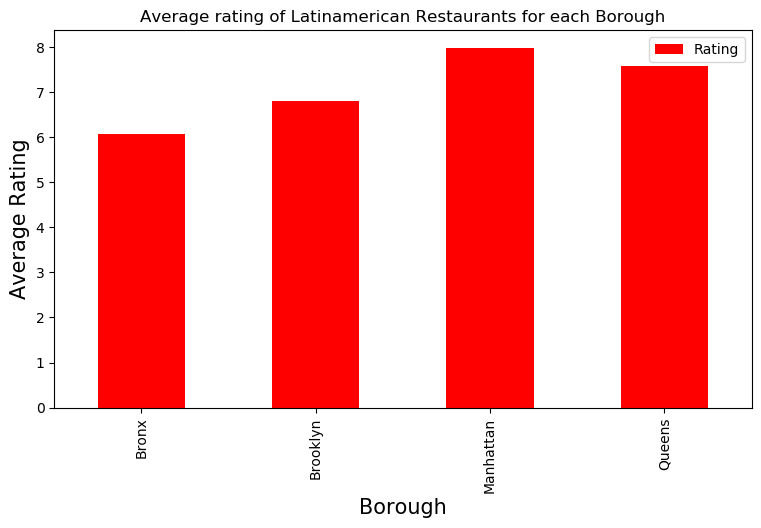

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Latinamerican Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
Lat_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color="red")
plt.legend()
plt.show()

## 4. Map Restaurants and places to start the new business

In [30]:
#Merge restaurants data with NY latitude and longitud dataset
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bushwick,40.698116,-73.925258,8.50
1,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.00
2,Brooklyn,Fort Greene,40.688527,-73.972906,9.20
3,Manhattan,Hamilton Heights,40.823604,-73.949688,8.30
4,Manhattan,Inwood,40.867684,-73.921210,8.10
5,Manhattan,Murray Hill,40.748303,-73.978332,8.00
6,Queens,Murray Hill,40.764126,-73.812763,8.00
7,Brooklyn,Prospect Heights,40.676822,-73.964859,9.20
8,Bronx,Unionport,40.829774,-73.850535,8.15
9,Manhattan,Upper East Side,40.775639,-73.960508,8.30


In [36]:
check3= ny_neighborhood_stats.groupby(["Borough"]).count()
check3

,Neighborhood,Latitude,Longitude,Average Rating,Label
Borough,,,,,
Bronx,2,2,2,2,2
Brooklyn,5,5,5,5,5
Manhattan,6,6,6,6,6
Queens,1,1,1,1,1


Manhattan has 6 of the 13 best rated restaurant and Brooklyn 5.

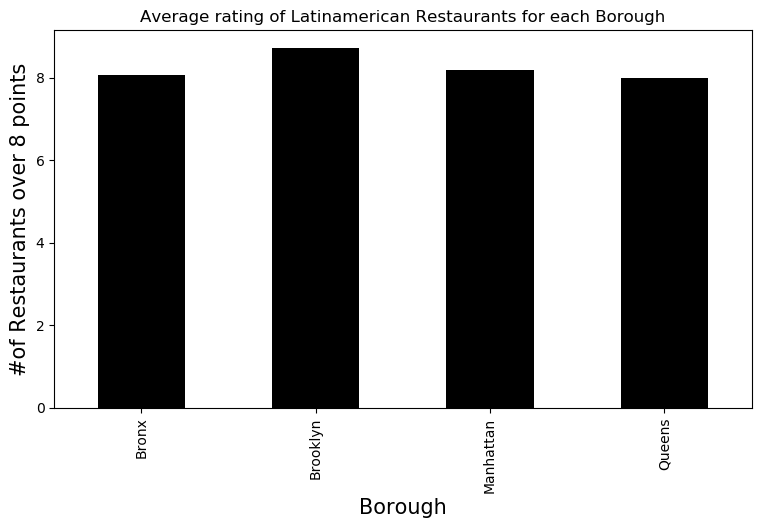

In [43]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Latinamerican Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('#of Restaurants over 8 points', fontsize=15)
ny_neighborhood_stats.groupby('Borough').mean()['Average Rating'].plot(kind='bar', color="black")
plt.show()

In [31]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [32]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Results  

    1.Manhattan and Queens have the best average rated Latinamerican restaurants on average. But Manhattan and Brooklyn have the highest quantity of best rated restaurant with 6 and 5 respectively.
    2.There are 306 neighborhoods and 5 Borough. 
    3. According to the data, there are 59 Lat Restaurants and 18 of them are in Brooklyn (highest number)
    4. The overall highest average rating is in Manhattan (7.98), and if we zoom into the over 8 points is Manhatan still the place with highest rating for Latinamerican Restaurant.
    5. I will recommend to open a restaurant in Manhatan.
 